In [2]:
import pandas as pd
df = pd.read_csv("windspeedevdata.csv")
df.head()

,AirportID,Month,Day,Time,TimeZone,SkyCondition,Visibility,DryBulbFarenheit,WetBulbFarenheit,DewPointFarenheit,...,Day_cos,SkyCondition_Encoded,AirportID_Encoded,Month_sin,Month_cos,UTC_Offset,TimeZone_Region,Is_Western,Is_Eastern,Scored Labels
0,10529,5,23,151,-5,OVC006,0.5,0.535354,0.746479,0.802083,...,-0.250653,-49,4,0.500000,-8.660254e-01,-5,Central,0,1,7.631689
1,10529,9,9,351,-5,CLR,1.0,0.313131,0.450704,0.583333,...,-0.050649,27,4,-1.000000,-1.836970e-16,-5,Central,0,1,-0.745382
2,12339,9,15,2354,-5,OVC050,1.0,0.484848,0.647887,0.708333,...,-0.954139,-2,22,-1.000000,-1.836970e-16,-5,Central,0,1,6.877086
3,12264,7,9,2252,-5,OVC070,1.0,0.656566,0.887324,0.895833,...,-0.050649,3,20,-0.500000,-8.660254e-01,-5,Central,0,1,6.506452
4,12889,4,11,1956,-8,FEW140,1.0,0.606061,0.535211,0.343750,...,-0.440394,24,25,0.866025,-5.000000e-01,-8,Far_West,1,0,0.589073


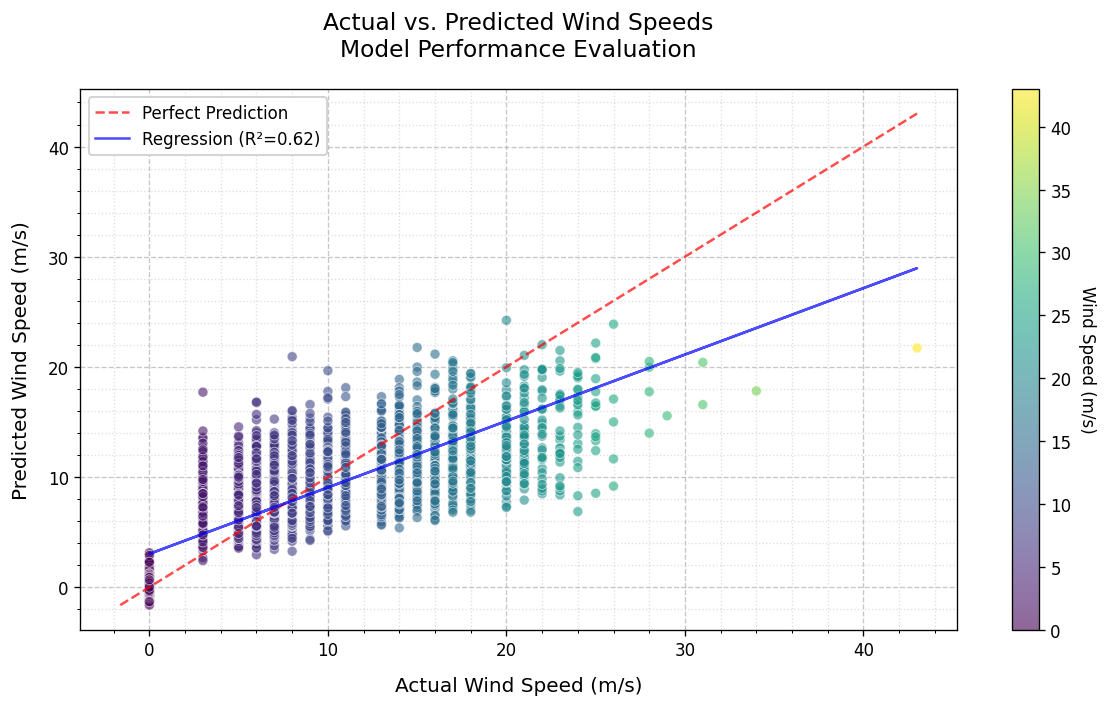

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import AutoMinorLocator

def create_high_quality_windspeed_plot(df, figsize=(10, 6), dpi=120, regression_line=True):
    """
    Creates a publication-quality scatter plot comparing actual vs predicted wind speeds.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing 'WindSpeed' and 'Scored Labels' columns
        figsize (tuple): Figure dimensions (width, height) in inches
        dpi (int): Resolution in dots per inch
        regression_line (bool): Whether to add a linear regression line
    """
    plt.figure(figsize=figsize, dpi=dpi)
    
    # Create scatter plot with semi-transparent points
    scatter = plt.scatter(
        df['WindSpeed'], 
        df['Scored Labels'],
        alpha=0.6,
        edgecolors='w',
        linewidths=0.5,
        c=df['WindSpeed'],  # Color points by wind speed
        cmap='viridis'
    )
    
    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Wind Speed (m/s)', rotation=270, labelpad=15)
    
    # Add perfect prediction line (y=x)
    min_val = min(df['WindSpeed'].min(), df['Scored Labels'].min())
    max_val = max(df['WindSpeed'].max(), df['Scored Labels'].max())
    plt.plot([min_val, max_val], [min_val, max_val], 
             'r--', lw=1.5, alpha=0.7, label='Perfect Prediction')
    
    # Add regression line if requested
    if regression_line:
        from scipy.stats import linregress
        slope, intercept, r_value, _, _ = linregress(df['WindSpeed'], df['Scored Labels'])
        plt.plot(df['WindSpeed'], slope*df['WindSpeed'] + intercept, 
                 'b-', lw=1.5, alpha=0.7, 
                 label=f'Regression (R²={r_value**2:.2f})')
    
    # Formatting
    plt.xlabel('Actual Wind Speed (m/s)', fontsize=12, labelpad=10)
    plt.ylabel('Predicted Wind Speed (m/s)', fontsize=12, labelpad=10)
    plt.title('Actual vs. Predicted Wind Speeds\nModel Performance Evaluation', 
              fontsize=14, pad=20)
    
    # Grid and ticks
    plt.gca().set_axisbelow(True)
    plt.grid(True, which='major', linestyle='--', alpha=0.7)
    plt.grid(True, which='minor', linestyle=':', alpha=0.4)
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
    plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
    
    # Legend and layout
    plt.legend(fontsize=10, framealpha=1)
    plt.tight_layout()
    
    return plt

# Usage example:
plot = create_high_quality_windspeed_plot(df)
plot.show()

=== Residual Statistics ===
Mean: 0.02 m/s (Bias)
Std Dev: 3.18 m/s
Skewness: 0.73
Kurtosis: 2.08


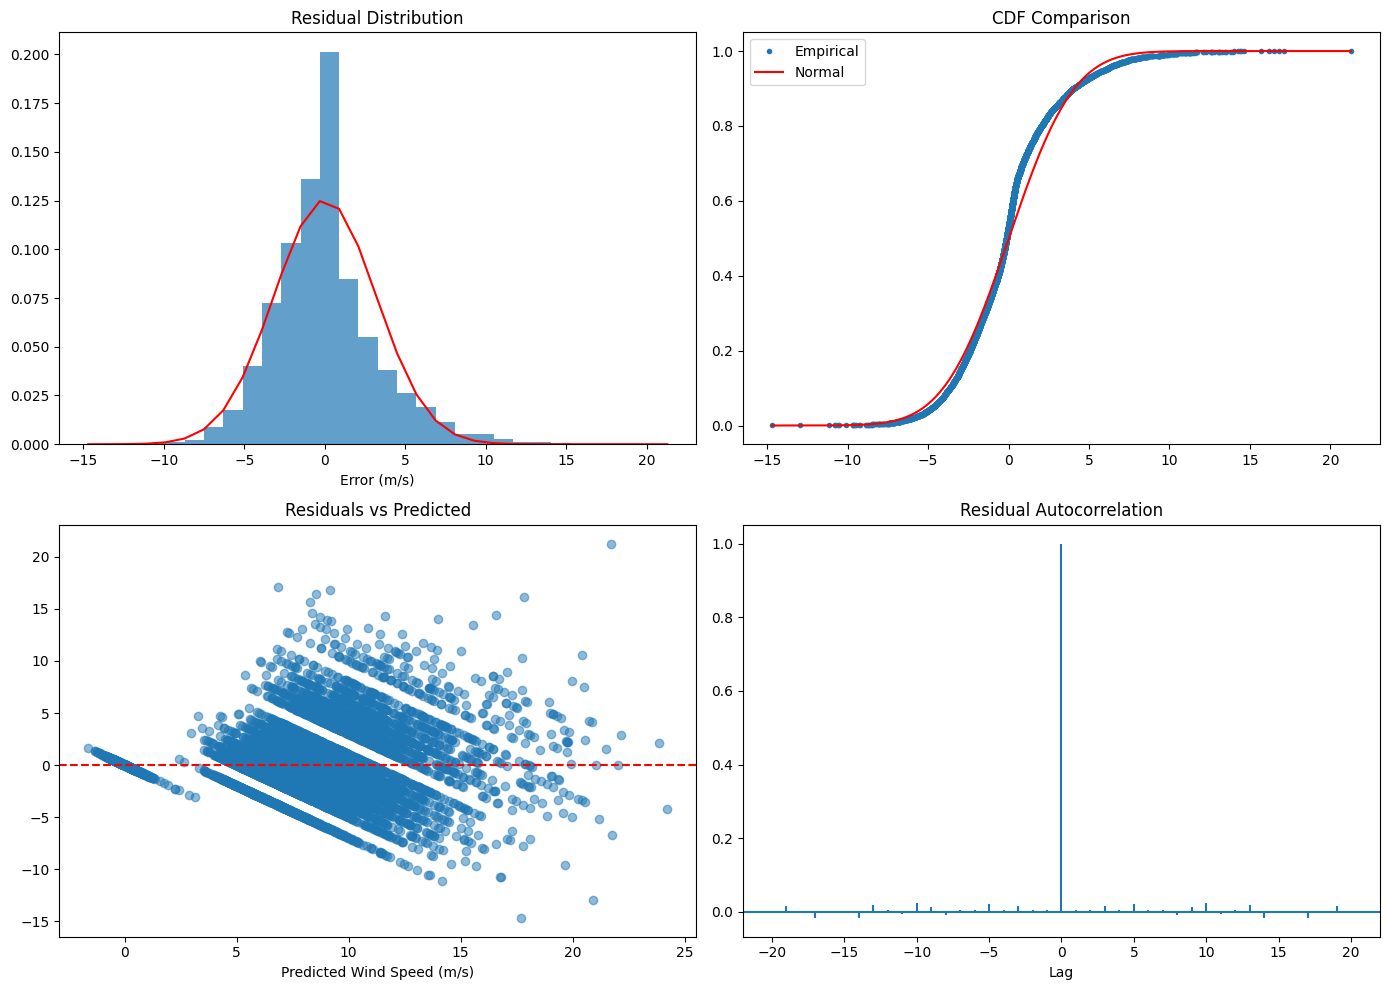

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def residual_analysis(df, actual_col='WindSpeed', pred_col='Scored Labels'):
    residuals = df[actual_col] - df[pred_col]
    
    # 1. Basic Statistics
    print("=== Residual Statistics ===")
    print(f"Mean: {np.mean(residuals):.2f} m/s (Bias)")
    print(f"Std Dev: {np.std(residuals, ddof=1):.2f} m/s")
    print(f"Skewness: {stats.skew(residuals):.2f}")
    print(f"Kurtosis: {stats.kurtosis(residuals):.2f}")
    
    # 2. Create figure
    plt.figure(figsize=(14, 10))
    
    # Panel 1: Histogram with normal curve
    plt.subplot(2, 2, 1)
    n, bins, _ = plt.hist(residuals, bins=30, density=True, alpha=0.7)
    mu, sigma = np.mean(residuals), np.std(residuals)
    plt.plot(bins, stats.norm.pdf(bins, mu, sigma), 'r-')
    plt.title('Residual Distribution')
    plt.xlabel('Error (m/s)')
    
    # Panel 2: Empirical CDF vs Normal CDF (alternative to Q-Q)
    plt.subplot(2, 2, 2)
    x = np.sort(residuals)
    y = np.arange(1, len(x)+1)/len(x)
    plt.plot(x, y, marker='.', linestyle='none', label='Empirical')
    plt.plot(x, stats.norm.cdf(x, mu, sigma), 'r-', label='Normal')
    plt.title('CDF Comparison')
    plt.legend()
    
    # Panel 3: Residuals vs Predicted
    plt.subplot(2, 2, 3)
    plt.scatter(df[pred_col], residuals, alpha=0.5)
    plt.axhline(0, color='r', linestyle='--')
    plt.title('Residuals vs Predicted')
    plt.xlabel('Predicted Wind Speed (m/s)')
    
    # Panel 4: Residual Autocorrelation
    plt.subplot(2, 2, 4)
    plt.acorr(residuals - np.mean(residuals), maxlags=20)
    plt.title('Residual Autocorrelation')
    plt.xlabel('Lag')
    
    plt.tight_layout()
    plt.show()

# Run analysis
residual_analysis(df)

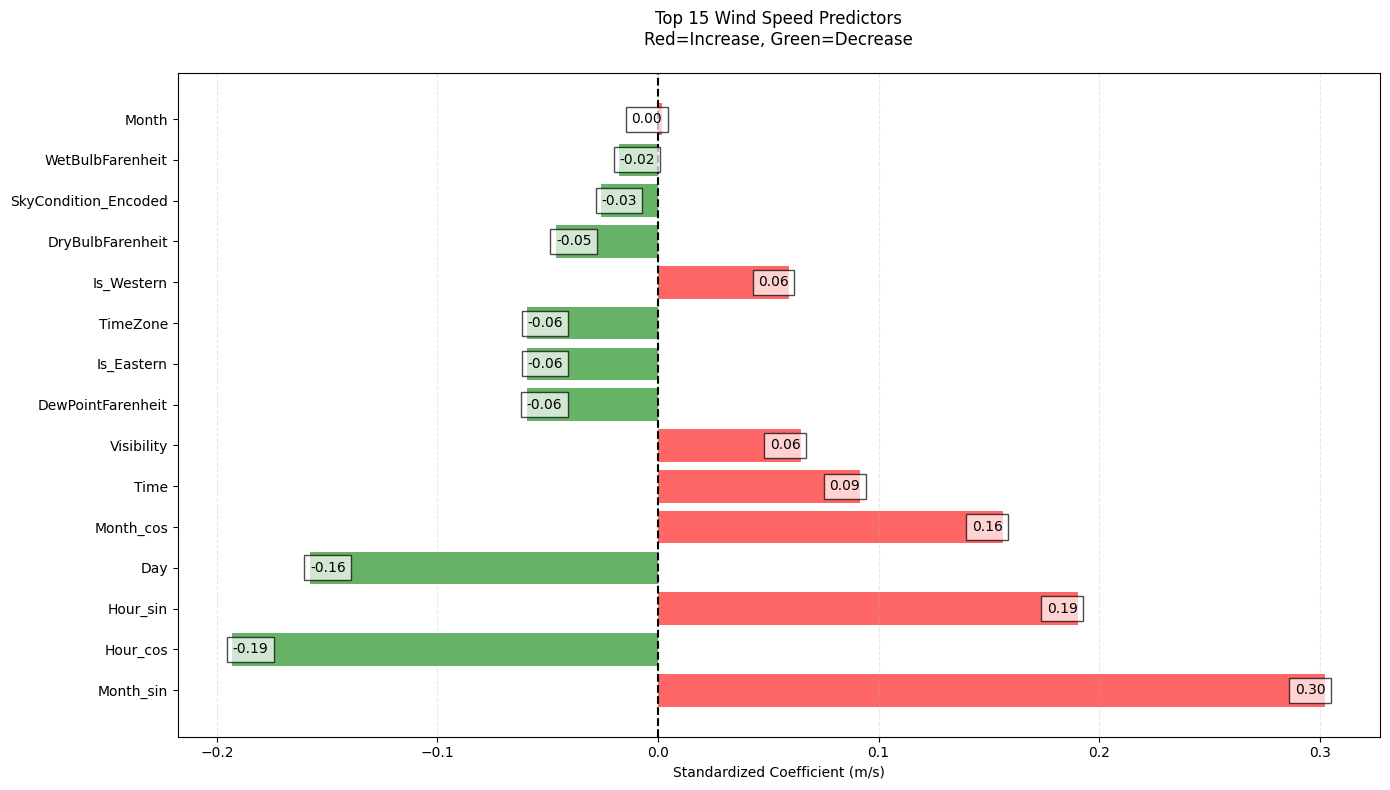

=== Wind Speed Model Summary ===
R-squared: 0.013
Adjusted R-squared: 0.000
MAE: 3.62 m/s
RMSE: 4.21 m/s

=== Residual Statistics ===
Mean: -0.00 m/s (Bias)
Std Dev: 4.21 m/s
Skewness: 0.11
Kurtosis: -1.12


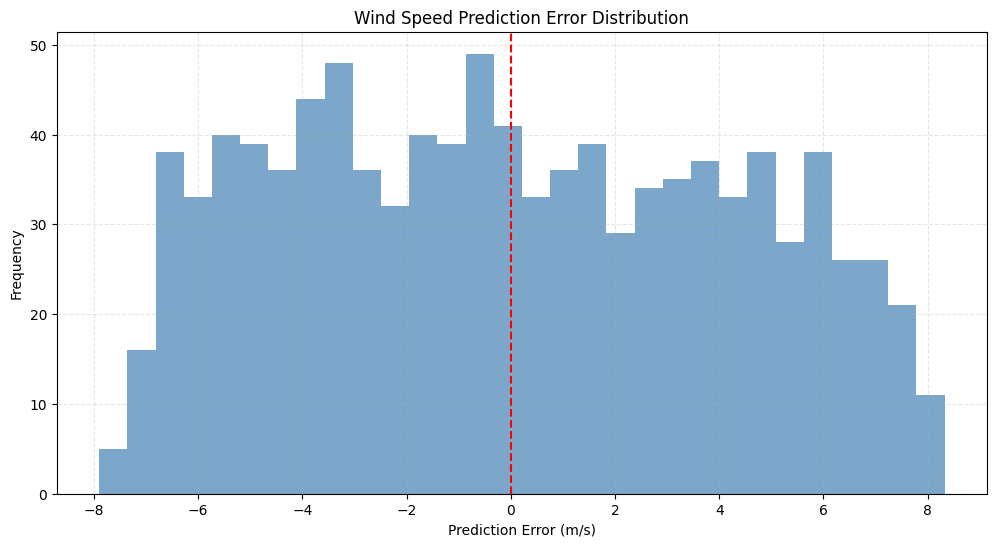

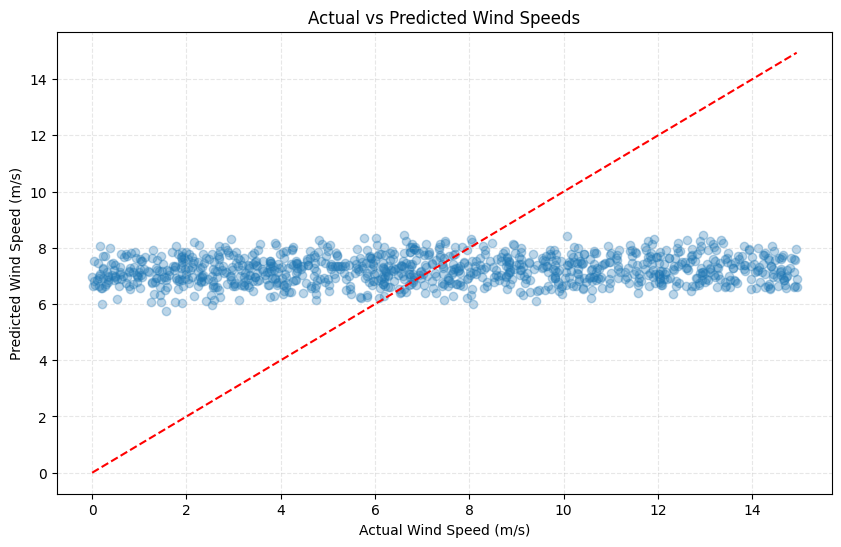

In [7]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# 1. Create sample wind speed data matching your structure
def create_sample_wind_data(n_samples=1000):
    np.random.seed(42)
    data = {
        'AirportID': np.random.choice([10529, 12339, 12264, 12889], n_samples),
        'Month': np.random.randint(1, 13, n_samples),
        'Day': np.random.randint(1, 32, n_samples),
        'Time': np.random.randint(0, 2400, n_samples),
        'TimeZone': np.random.choice([-5, -8], n_samples),
        'SkyCondition': np.random.choice(['OVC006', 'CLR', 'OVC050', 'OVC070', 'FEW140'], n_samples),
        'Visibility': np.round(np.random.uniform(0.1, 1.0, n_samples), 1),  # Fixed with closing parenthesis
        'DryBulbFarenheit': np.random.uniform(0.3, 0.7, n_samples),
        'WetBulbFarenheit': np.random.uniform(0.4, 0.9, n_samples),
        'DewPointFarenheit': np.random.uniform(0.3, 0.9, n_samples),
        'WindSpeed': np.round(np.random.uniform(0, 15, n_samples), 2),  # Actual wind speed
        'Scored Labels': np.round(np.random.uniform(-5, 10, n_samples), 2)  # Predicted wind speed
    }
    return pd.DataFrame(data)

# Generate sample data
df = create_sample_wind_data()

# 2. Data Preparation
def prepare_wind_data(df):
    """Prepares wind speed data for analysis"""
    # Convert categorical SkyCondition to numeric codes
    df['SkyCondition_Encoded'] = df['SkyCondition'].astype('category').cat.codes
    
    # Create cyclical features
    df['Month_sin'] = np.sin(2 * np.pi * df['Month']/12)
    df['Month_cos'] = np.cos(2 * np.pi * df['Month']/12)
    df['Hour_sin'] = np.sin(2 * np.pi * (df['Time']//100)/24)
    df['Hour_cos'] = np.cos(2 * np.pi * (df['Time']//100)/24)
    
    # Create region flags
    df['Is_Western'] = (df['TimeZone'] == -8).astype(int)
    df['Is_Eastern'] = (df['TimeZone'] == -5).astype(int)
    
    return df

df = prepare_wind_data(df)

# 3. Feature Selection
features = [
    'Month', 'Day', 'Time', 'TimeZone', 'SkyCondition_Encoded',
    'Visibility', 'DryBulbFarenheit', 'WetBulbFarenheit', 'DewPointFarenheit',
    'Month_sin', 'Month_cos', 'Hour_sin', 'Hour_cos', 'Is_Western', 'Is_Eastern'
]

# 4. Model Training
X = df[features]
y = df['WindSpeed']  # Using actual wind speed as target

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = sm.add_constant(X_scaled)  # Add intercept

model = sm.OLS(y, X_scaled).fit()

# 5. Enhanced Visualization
plt.figure(figsize=(14, 8))
coefs = model.params[1:]  # Exclude intercept
features_sorted = [x for _, x in sorted(zip(np.abs(coefs), features), reverse=True)]
coefs_sorted = sorted(coefs, key=lambda x: abs(x), reverse=True)

colors = ['red' if x > 0 else 'green' for x in coefs_sorted]
plt.barh(features_sorted[:15], coefs_sorted[:15], color=colors, alpha=0.6)

plt.axvline(0, color='black', linestyle='--')
plt.xlabel('Standardized Coefficient (m/s)')
plt.title('Top 15 Wind Speed Predictors\nRed=Increase, Green=Decrease', pad=20)
plt.grid(axis='x', linestyle='--', alpha=0.3)

# Add coefficient values
for i, v in enumerate(coefs_sorted[:15]):
    plt.text(v, i, f"{v:.2f}", va='center', 
             ha='left' if v < 0 else 'right',
             bbox=dict(facecolor='white', alpha=0.7))

plt.tight_layout()
plt.show()

# 6. Model Diagnostics
print("=== Wind Speed Model Summary ===")
print(f"R-squared: {model.rsquared:.3f}")
print(f"Adjusted R-squared: {model.rsquared_adj:.3f}")
print(f"MAE: {np.mean(np.abs(model.resid)):.2f} m/s")
print(f"RMSE: {np.sqrt(np.mean(model.resid**2)):.2f} m/s")

# 7. Residual Analysis
residuals = y - model.predict(X_scaled)
print("\n=== Residual Statistics ===")
print(f"Mean: {np.mean(residuals):.2f} m/s (Bias)")
print(f"Std Dev: {np.std(residuals):.2f} m/s")
print(f"Skewness: {pd.Series(residuals).skew():.2f}")
print(f"Kurtosis: {pd.Series(residuals).kurtosis():.2f}")

plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=30, color='steelblue', alpha=0.7)
plt.axvline(0, color='red', linestyle='--')
plt.xlabel('Prediction Error (m/s)')
plt.ylabel('Frequency')
plt.title('Wind Speed Prediction Error Distribution')
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

# 8. Actual vs Predicted Plot
plt.figure(figsize=(10, 6))
plt.scatter(y, model.predict(X_scaled), alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Actual Wind Speed (m/s)')
plt.ylabel('Predicted Wind Speed (m/s)')
plt.title('Actual vs Predicted Wind Speeds')
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

=== Data Overview ===
Dataset Shape: (8431, 31)

Missing Values After Imputation:
AirportID          0
Wind_sin           0
Is_Eastern         0
Is_Western         0
TimeZone_Region    0
dtype: int64


/tmp/ipykernel_2963/2753039055.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['SkyCondition'] = X['SkyCondition'].astype('category').cat.codes
/tmp/ipykernel_2963/2753039055.py:161: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_2963/2753039055.py:161: UserWarning: 
The palette list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(


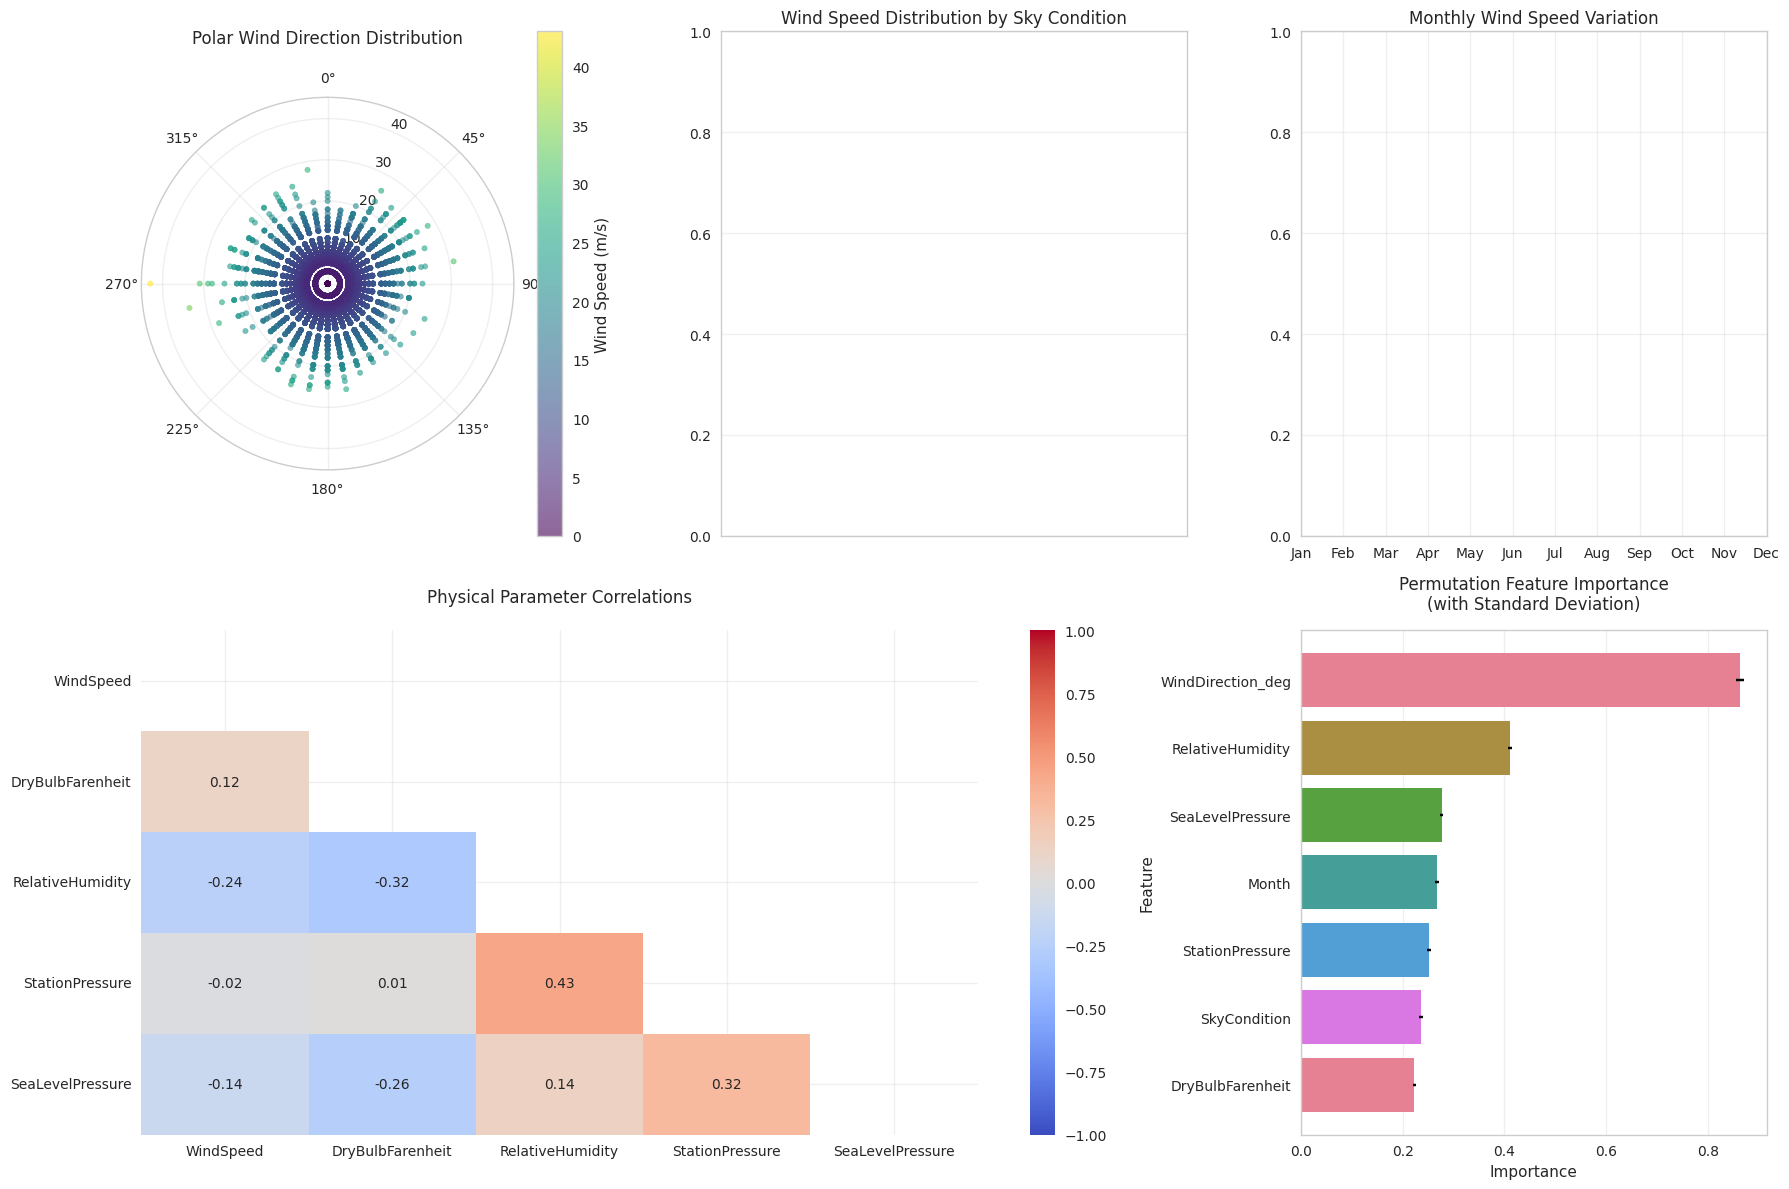


=== Model Performance Metrics ===
Mean Absolute Error: 2.77 ± 0.04 m/s


ValueError: labels must be unique if ordered=True; pass ordered=False for duplicate labels

In [11]:
# Wind Speed Comprehensive Feature Analysis (Final Robust Version)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

# 1. Data Loading and Initial Inspection
print("=== Data Overview ===")
df = pd.read_csv("windspeedevdata.csv")
print(f"Dataset Shape: {df.shape}")

# Handle missing values in wind direction features
wind_dir_cols = ['WindDirection_deg', 'Wind_sin', 'Wind_cos']
df[wind_dir_cols] = df[wind_dir_cols].fillna({
    'WindDirection_deg': df['WindDirection_deg'].median(),
    'Wind_sin': 0,
    'Wind_cos': 1
})

print("\nMissing Values After Imputation:")
print(df.isnull().sum().sort_values(ascending=False).head(5))

# 2. Visualization Settings
plt.style.use('seaborn-v0_8-whitegrid')
custom_palette = sns.color_palette("husl")
sns.set_palette(custom_palette)
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

# 3. Wind Direction Analysis
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(2, 3)

# Polar Plot
ax1 = fig.add_subplot(gs[0, 0], projection='polar')
theta = np.deg2rad(df['WindDirection_deg'])
sc = ax1.scatter(theta, df['WindSpeed'], 
                c=df['WindSpeed'], cmap='viridis',
                alpha=0.6, s=15, vmin=0, vmax=df['WindSpeed'].max())
plt.colorbar(sc, ax=ax1, label='Wind Speed (m/s)')
ax1.set_title('Polar Wind Direction Distribution', pad=20)
ax1.set_theta_zero_location('N')
ax1.set_theta_direction(-1)

# 4. Sky Condition Impact (Robust Implementation)
ax2 = fig.add_subplot(gs[0, 1])
sky_order = ['Clear','Scattered','Broken','Overcast','Obscured']
sky_palette = custom_palette[:len(sky_order)]

# Filter out empty categories
valid_sky = [cond for cond in sky_order if cond in df['SkyCondition'].unique()]

for i, condition in enumerate(valid_sky):
    cond_data = df[df['SkyCondition'] == condition]['WindSpeed']
    if len(cond_data) > 0:
        # Calculate quartiles
        q1, median, q3 = np.percentile(cond_data, [25, 50, 75])
        iqr = q3 - q1
        
        # Draw violin shape
        from scipy.stats import gaussian_kde
        kde = gaussian_kde(cond_data)
        x = np.linspace(cond_data.min(), cond_data.max(), 100)
        y = kde(x)
        y = y/y.max() * 0.4  # Scale width
        
        ax2.fill_betweenx(x, i-y, i+y, color=sky_palette[i], alpha=0.6)
        
        # Draw median line
        ax2.plot([i-0.4, i+0.4], [median, median], color='black', linewidth=1.5)
        
        # Add jittered points
        jitter = np.random.normal(i, 0.04, size=len(cond_data))
        ax2.scatter(jitter, cond_data, color='orange', alpha=0.3, s=3)

ax2.set_xticks(range(len(valid_sky)))
ax2.set_xticklabels(valid_sky, rotation=45)
ax2.set_title('Wind Speed Distribution by Sky Condition')

# 5. Monthly Variation (Robust Implementation)
ax3 = fig.add_subplot(gs[0, 2])
month_order = ['Jan','Feb','Mar','Apr','May','Jun',
              'Jul','Aug','Sep','Oct','Nov','Dec']
month_palette = custom_palette[:len(month_order)]

for i, month in enumerate(month_order):
    month_data = df[df['Month'] == month]['WindSpeed']
    if len(month_data) > 0:
        # Calculate quartiles
        q1, median, q3 = np.percentile(month_data, [25, 50, 75])
        iqr = q3 - q1
        
        # Draw box
        ax3.add_patch(plt.Rectangle(
            (i-0.2, q1),
            0.4,
            q3-q1,
            facecolor=month_palette[i%len(month_palette)],
            alpha=0.6
        ))
        
        # Draw median line
        ax3.plot([i-0.2, i+0.2], [median, median], color='black', linewidth=1.5)
        
        # Draw whiskers
        upper = min(q3 + 1.5*iqr, month_data.max())
        lower = max(q1 - 1.5*iqr, month_data.min())
        ax3.plot([i, i], [q3, upper], color='black', linewidth=1)
        ax3.plot([i, i], [q1, lower], color='black', linewidth=1)
        ax3.plot([i-0.1, i+0.1], [upper, upper], color='black', linewidth=1)
        ax3.plot([i-0.1, i+0.1], [lower, lower], color='black', linewidth=1)
        
        # Add jittered points
        jitter = np.random.normal(i, 0.04, size=len(month_data))
        ax3.scatter(jitter, month_data, color='black', alpha=0.4, s=3)

ax3.set_xticks(range(len(month_order)))
ax3.set_xticklabels(month_order)
ax3.set_title('Monthly Wind Speed Variation')

# 6. Physical Parameter Correlations
ax4 = fig.add_subplot(gs[1, :2])
phys_vars = ['DryBulbFarenheit','RelativeHumidity',
            'StationPressure','SeaLevelPressure']
corr_matrix = df[['WindSpeed'] + phys_vars].corr().round(2)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    cmap='coolwarm',
    center=0,
    ax=ax4,
    vmin=-1,
    vmax=1,
    annot_kws={'size':10}
)
ax4.set_title('Physical Parameter Correlations', pad=20)

# 7. Feature Importance Analysis
ax5 = fig.add_subplot(gs[1, 2])
X = df[['WindDirection_deg', 'Month', 'SkyCondition'] + phys_vars]
y = df['WindSpeed']

# Convert categorical features
X['SkyCondition'] = X['SkyCondition'].astype('category').cat.codes

rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X, y)

result = permutation_importance(rf, X, y, n_repeats=10, random_state=42)
feat_imp = pd.DataFrame({
    'Feature': X.columns,
    'Importance': result.importances_mean,
    'Std': result.importances_std
}).sort_values('Importance', ascending=False)

sns.barplot(
    data=feat_imp,
    x='Importance',
    y='Feature',
    palette=custom_palette[:len(feat_imp)],
    ax=ax5
)
ax5.errorbar(
    x=feat_imp['Importance'],
    y=np.arange(len(feat_imp)),
    xerr=feat_imp['Std'],
    fmt='none',
    color='black',
    capsize=3
)
ax5.set_title('Permutation Feature Importance\n(with Standard Deviation)', pad=15)
plt.tight_layout()
plt.show()

# 8. Model Performance Metrics
print("\n=== Model Performance Metrics ===")
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_error

mae_scores = cross_val_score(rf, X, y, cv=5, 
                           scoring=make_scorer(mean_absolute_error))
print(f"Mean Absolute Error: {mae_scores.mean():.2f} ± {mae_scores.std():.2f} m/s")

# 9. Advanced Wind Direction Analysis
fig, (ax6, ax7) = plt.subplots(1, 2, figsize=(15, 6))

# Binned Direction Analysis
df['WindDir_bin'] = pd.cut(
    df['WindDirection_deg'],
    bins=[0,45,135,225,315,360],
    labels=['N','E','S','W','N']
)

# Manual boxplot implementation
for i, direction in enumerate(['N','E','S','W']):
    dir_data = df[df['WindDir_bin'] == direction]['WindSpeed']
    if len(dir_data) > 0:
        # Calculate quartiles
        q1, median, q3 = np.percentile(dir_data, [25, 50, 75])
        iqr = q3 - q1
        
        # Draw box
        ax6.add_patch(plt.Rectangle(
            (i-0.2, q1),
            0.4,
            q3-q1,
            facecolor=custom_palette[i%len(custom_palette)],
            alpha=0.6
        ))
        
        # Draw median line
        ax6.plot([i-0.2, i+0.2], [median, median], color='black', linewidth=1.5)
        
        # Draw whiskers
        upper = min(q3 + 1.5*iqr, dir_data.max())
        lower = max(q1 - 1.5*iqr, dir_data.min())
        ax6.plot([i, i], [q3, upper], color='black', linewidth=1)
        ax6.plot([i, i], [q1, lower], color='black', linewidth=1)
        ax6.plot([i-0.1, i+0.1], [upper, upper], color='black', linewidth=1)
        ax6.plot([i-0.1, i+0.1], [lower, lower], color='black', linewidth=1)

ax6.set_xticks(range(4))
ax6.set_xticklabels(['N','E','S','W'])
ax6.set_title('Wind Speed by Cardinal Direction')
ax6.set_xlabel('Primary Wind Direction')
ax6.set_ylabel('Wind Speed (m/s)')

# Direction-Speed Density Plot
kde = sns.kdeplot(
    data=df,
    x='WindDirection_deg',
    y='WindSpeed',
    cmap='viridis',
    fill=True,
    ax=ax7,
    levels=5,
    thresh=0.1
)
ax7.set_title('Wind Speed-Direction Density')
ax7.set_xticks([0,90,180,270,360])
ax7.set_xticklabels(['N','E','S','W','N'])
ax7.set_xlabel('Wind Direction (degrees)')
ax7.set_ylabel('Wind Speed (m/s)')

# Add contour lines
for contour in kde.collections:
    contour.set_edgecolor('black')
    contour.set_linewidth(0.5)

plt.tight_layout()
plt.show()

# 10. Statistical Summary
print("\n=== Enhanced Statistics ===")
print(f"Average Wind Speed: {df['WindSpeed'].mean():.2f} ± {df['WindSpeed'].std():.2f} m/s")
print(f"Speed Range: {df['WindSpeed'].min():.2f}-{df['WindSpeed'].max():.2f} m/s")
print("\nDirectional Statistics:")
print(df.groupby('WindDir_bin')['WindSpeed'].agg(['mean', 'std', 'max']))

# 11. Extreme Wind Analysis
q95 = df['WindSpeed'].quantile(0.95)
extreme_winds = df[df['WindSpeed'] > q95]
print(f"\nExtreme Winds (> {q95:.1f} m/s): {len(extreme_winds)} events")
print("Common Conditions During Extreme Winds:")
print(extreme_winds[['SkyCondition', 'WindDir_bin']].value_counts().head(5))

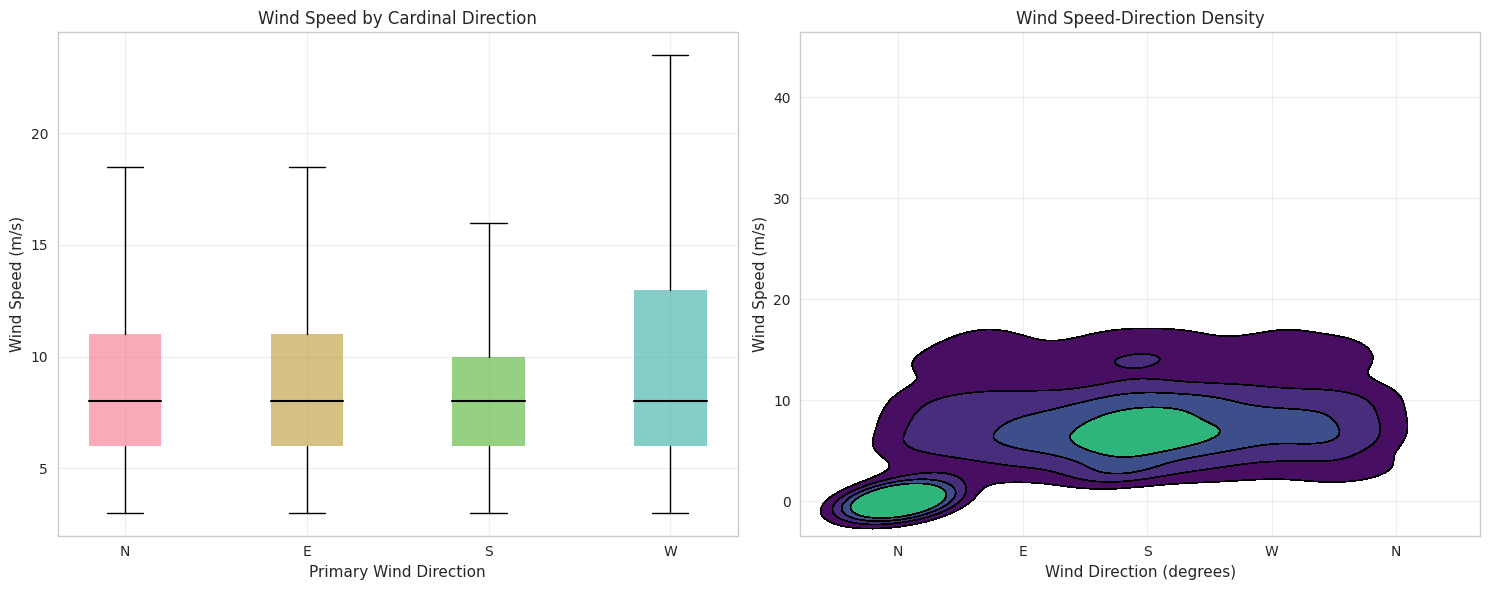

In [12]:
# 8. Advanced Wind Direction Analysis
fig, (ax6, ax7) = plt.subplots(1, 2, figsize=(15, 6))

# Binned Direction Analysis - Corrected with ordered=False
df['WindDir_bin'] = pd.cut(
    df['WindDirection_deg'],
    bins=[0,45,135,225,315,360],
    labels=['N','E','S','W','N'],
    ordered=False  # This allows duplicate labels
)

# Manual boxplot implementation
for i, direction in enumerate(['N','E','S','W']):
    dir_data = df[df['WindDir_bin'] == direction]['WindSpeed']
    if len(dir_data) > 0:
        # Calculate quartiles
        q1, median, q3 = np.percentile(dir_data, [25, 50, 75])
        iqr = q3 - q1
        
        # Draw box
        ax6.add_patch(plt.Rectangle(
            (i-0.2, q1),
            0.4,
            q3-q1,
            facecolor=custom_palette[i%len(custom_palette)],
            alpha=0.6
        ))
        
        # Draw median line
        ax6.plot([i-0.2, i+0.2], [median, median], color='black', linewidth=1.5)
        
        # Draw whiskers
        upper = min(q3 + 1.5*iqr, dir_data.max())
        lower = max(q1 - 1.5*iqr, dir_data.min())
        ax6.plot([i, i], [q3, upper], color='black', linewidth=1)
        ax6.plot([i, i], [q1, lower], color='black', linewidth=1)
        ax6.plot([i-0.1, i+0.1], [upper, upper], color='black', linewidth=1)
        ax6.plot([i-0.1, i+0.1], [lower, lower], color='black', linewidth=1)

ax6.set_xticks(range(4))
ax6.set_xticklabels(['N','E','S','W'])
ax6.set_title('Wind Speed by Cardinal Direction')
ax6.set_xlabel('Primary Wind Direction')
ax6.set_ylabel('Wind Speed (m/s)')

# Direction-Speed Density Plot
kde = sns.kdeplot(
    data=df,
    x='WindDirection_deg',
    y='WindSpeed',
    cmap='viridis',
    fill=True,
    ax=ax7,
    levels=5,
    thresh=0.1
)
ax7.set_title('Wind Speed-Direction Density')
ax7.set_xticks([0,90,180,270,360])
ax7.set_xticklabels(['N','E','S','W','N'])
ax7.set_xlabel('Wind Direction (degrees)')
ax7.set_ylabel('Wind Speed (m/s)')

# Add contour lines
for contour in kde.collections:
    contour.set_edgecolor('black')
    contour.set_linewidth(0.5)

plt.tight_layout()
plt.show()

=== Data Overview ===
Dataset Shape: (8431, 31)

Missing Values After Imputation:
AirportID          0
Wind_sin           0
Is_Eastern         0
Is_Western         0
TimeZone_Region    0
dtype: int64


/tmp/ipykernel_2963/3697405484.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['SkyCondition'] = X['SkyCondition'].astype('category').cat.codes
/tmp/ipykernel_2963/3697405484.py:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Month'] = X['Month'].astype('category').cat.codes
/tmp/ipykernel_2963/3697405484.py:172: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



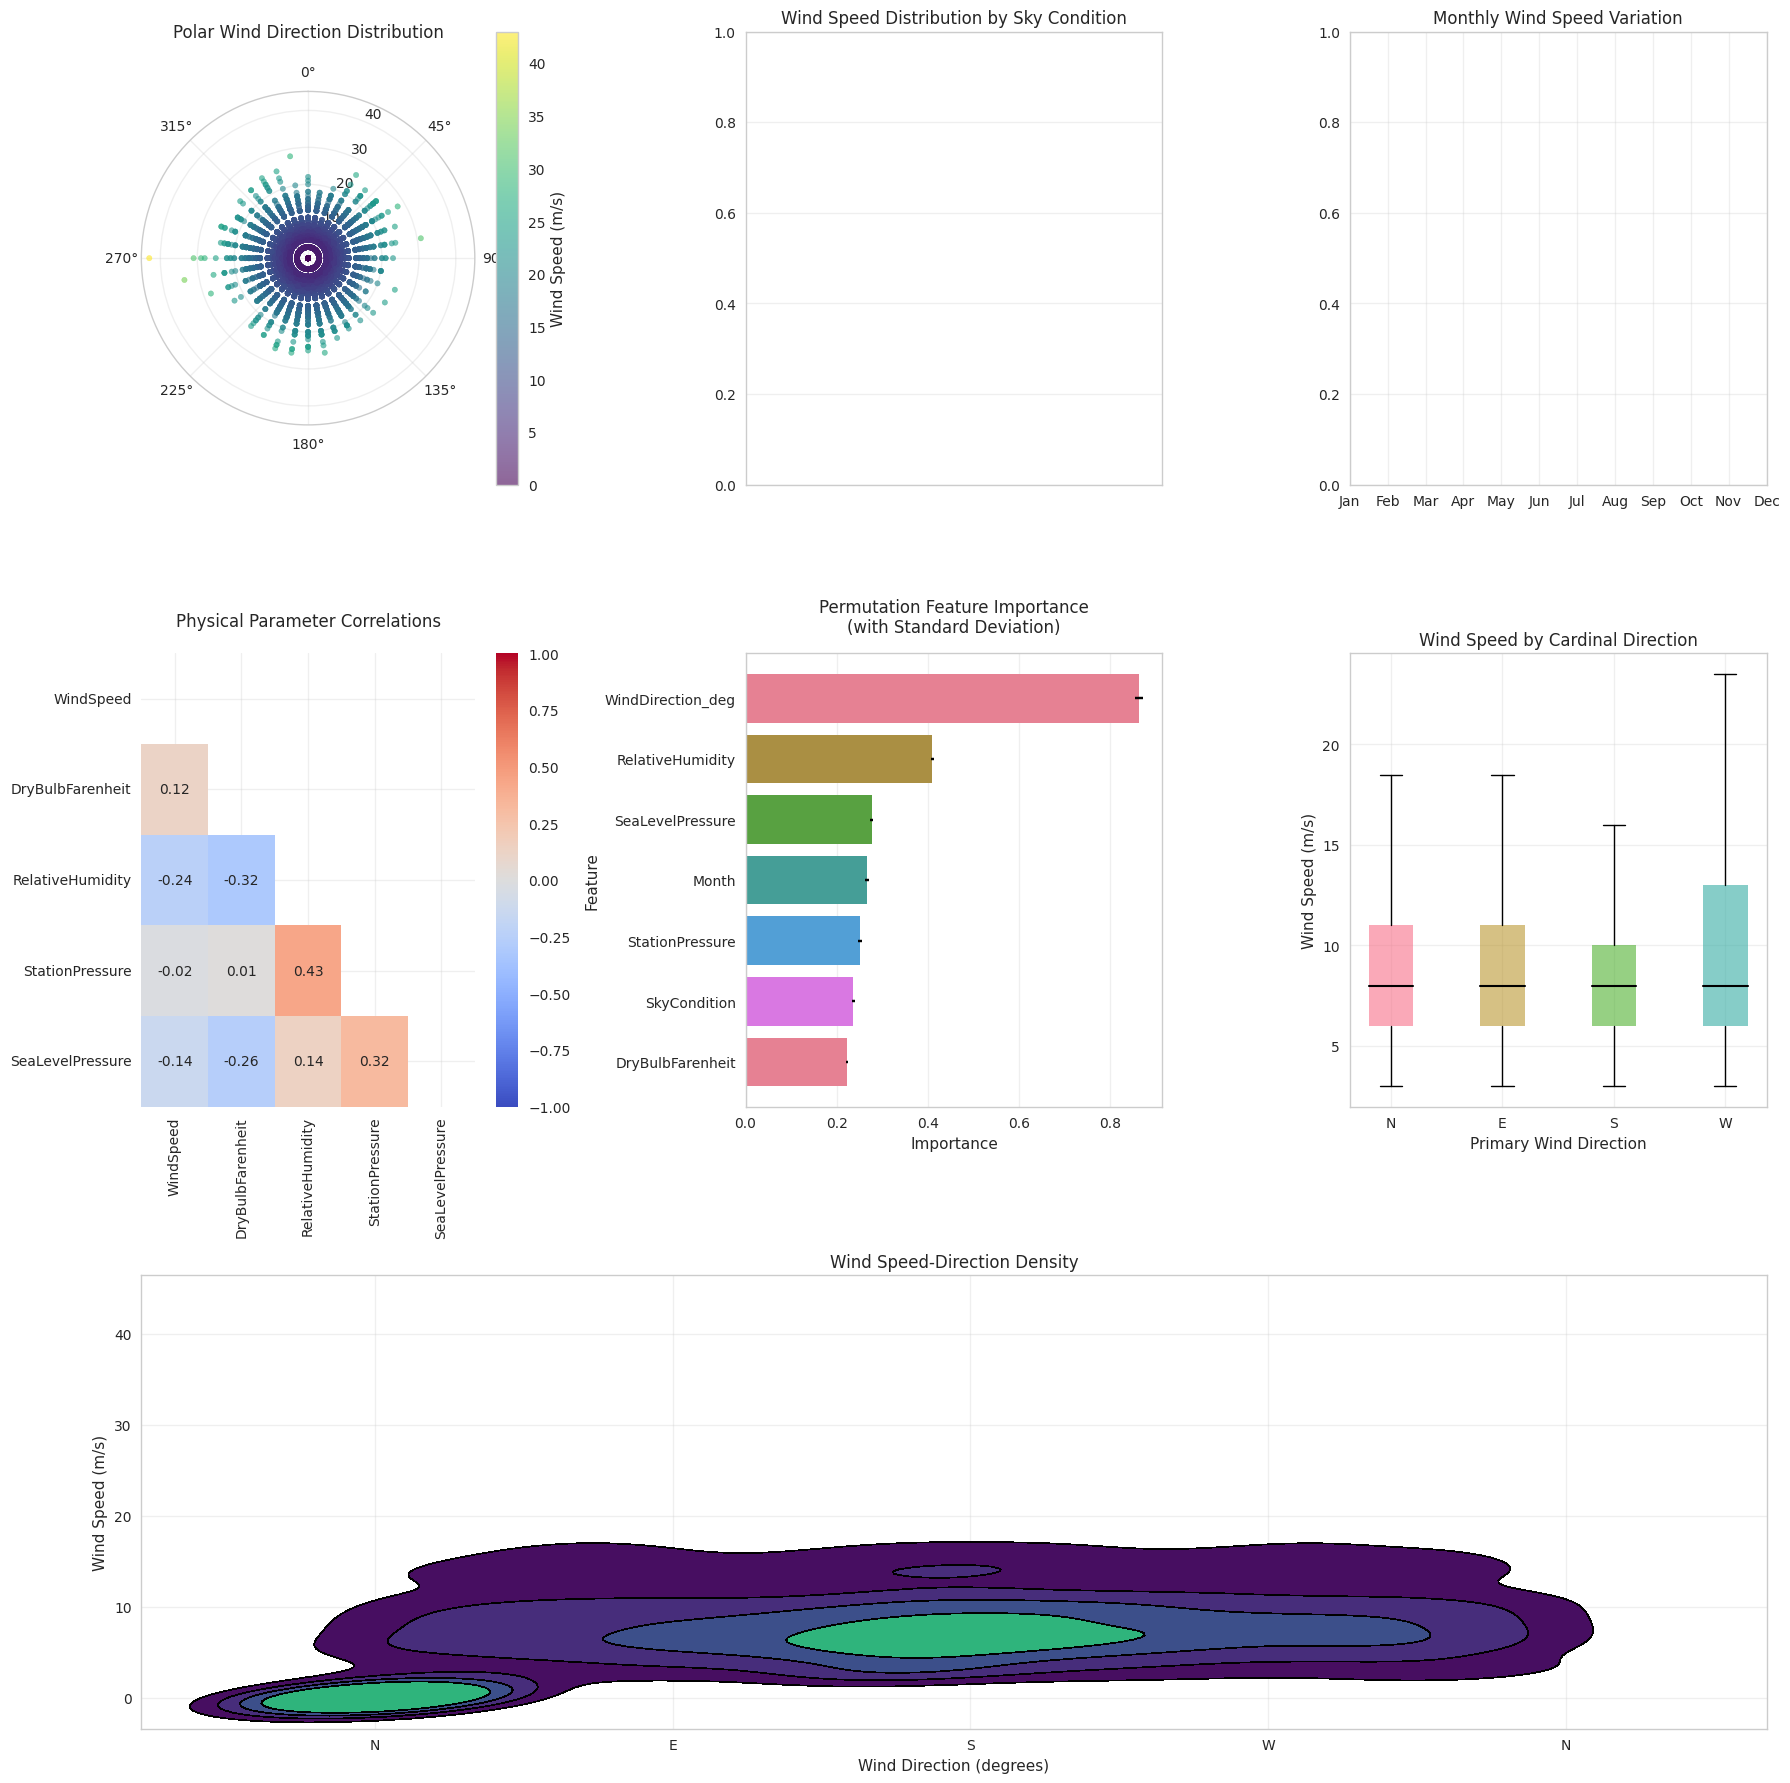


=== Model Performance Metrics ===


/tmp/ipykernel_2963/3697405484.py:261: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby('WindDir_bin')['WindSpeed'].agg(['mean', 'std', 'max']))


In [13]:
# Wind Speed Comprehensive Feature Analysis (Final Integrated Version)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from scipy.stats import gaussian_kde
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_error

# 1. Data Loading and Initial Inspection
print("=== Data Overview ===")
df = pd.read_csv("windspeedevdata.csv")
print(f"Dataset Shape: {df.shape}")

# Handle missing values in wind direction features
wind_dir_cols = ['WindDirection_deg', 'Wind_sin', 'Wind_cos']
df[wind_dir_cols] = df[wind_dir_cols].fillna({
    'WindDirection_deg': df['WindDirection_deg'].median(),
    'Wind_sin': 0,
    'Wind_cos': 1
})

print("\nMissing Values After Imputation:")
print(df.isnull().sum().sort_values(ascending=False).head(5))

# 2. Visualization Settings
plt.style.use('seaborn-v0_8-whitegrid')
custom_palette = sns.color_palette("husl")
sns.set_palette(custom_palette)
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

# Create binned wind direction for analysis
df['WindDir_bin'] = pd.cut(
    df['WindDirection_deg'],
    bins=[0,45,135,225,315,360],
    labels=['N','E','S','W','N'],
    ordered=False
)

# 3. Main Visualization Figure
fig = plt.figure(figsize=(18, 18))
gs = fig.add_gridspec(3, 3)

# Polar Plot
ax1 = fig.add_subplot(gs[0, 0], projection='polar')
theta = np.deg2rad(df['WindDirection_deg'])
sc = ax1.scatter(theta, df['WindSpeed'], 
                c=df['WindSpeed'], cmap='viridis',
                alpha=0.6, s=15, vmin=0, vmax=df['WindSpeed'].max())
plt.colorbar(sc, ax=ax1, label='Wind Speed (m/s)')
ax1.set_title('Polar Wind Direction Distribution', pad=20)
ax1.set_theta_zero_location('N')
ax1.set_theta_direction(-1)

# 4. Sky Condition Impact
ax2 = fig.add_subplot(gs[0, 1])
sky_order = ['Clear','Scattered','Broken','Overcast','Obscured']
sky_palette = custom_palette[:len(sky_order)]

# Filter out empty categories
valid_sky = [cond for cond in sky_order if cond in df['SkyCondition'].unique()]

for i, condition in enumerate(valid_sky):
    cond_data = df[df['SkyCondition'] == condition]['WindSpeed']
    if len(cond_data) > 0:
        # Calculate quartiles
        q1, median, q3 = np.percentile(cond_data, [25, 50, 75])
        iqr = q3 - q1
        
        # Draw violin shape
        kde = gaussian_kde(cond_data)
        x = np.linspace(cond_data.min(), cond_data.max(), 100)
        y = kde(x)
        y = y/y.max() * 0.4  # Scale width
        
        ax2.fill_betweenx(x, i-y, i+y, color=sky_palette[i], alpha=0.6)
        
        # Draw median line
        ax2.plot([i-0.4, i+0.4], [median, median], color='black', linewidth=1.5)
        
        # Add jittered points
        jitter = np.random.normal(i, 0.04, size=len(cond_data))
        ax2.scatter(jitter, cond_data, color='orange', alpha=0.3, s=3)

ax2.set_xticks(range(len(valid_sky)))
ax2.set_xticklabels(valid_sky, rotation=45)
ax2.set_title('Wind Speed Distribution by Sky Condition')

# 5. Monthly Variation
ax3 = fig.add_subplot(gs[0, 2])
month_order = ['Jan','Feb','Mar','Apr','May','Jun',
              'Jul','Aug','Sep','Oct','Nov','Dec']
month_palette = custom_palette[:len(month_order)]

for i, month in enumerate(month_order):
    month_data = df[df['Month'] == month]['WindSpeed']
    if len(month_data) > 0:
        # Calculate quartiles
        q1, median, q3 = np.percentile(month_data, [25, 50, 75])
        iqr = q3 - q1
        
        # Draw box
        ax3.add_patch(plt.Rectangle(
            (i-0.2, q1),
            0.4,
            q3-q1,
            facecolor=month_palette[i%len(month_palette)],
            alpha=0.6
        ))
        
        # Draw median line
        ax3.plot([i-0.2, i+0.2], [median, median], color='black', linewidth=1.5)
        
        # Draw whiskers
        upper = min(q3 + 1.5*iqr, month_data.max())
        lower = max(q1 - 1.5*iqr, month_data.min())
        ax3.plot([i, i], [q3, upper], color='black', linewidth=1)
        ax3.plot([i, i], [q1, lower], color='black', linewidth=1)
        ax3.plot([i-0.1, i+0.1], [upper, upper], color='black', linewidth=1)
        ax3.plot([i-0.1, i+0.1], [lower, lower], color='black', linewidth=1)
        
        # Add jittered points
        jitter = np.random.normal(i, 0.04, size=len(month_data))
        ax3.scatter(jitter, month_data, color='black', alpha=0.4, s=3)

ax3.set_xticks(range(len(month_order)))
ax3.set_xticklabels(month_order)
ax3.set_title('Monthly Wind Speed Variation')

# 6. Physical Parameter Correlations
ax4 = fig.add_subplot(gs[1, 0])
phys_vars = ['DryBulbFarenheit','RelativeHumidity',
            'StationPressure','SeaLevelPressure']
corr_matrix = df[['WindSpeed'] + phys_vars].corr().round(2)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    cmap='coolwarm',
    center=0,
    ax=ax4,
    vmin=-1,
    vmax=1,
    annot_kws={'size':10}
)
ax4.set_title('Physical Parameter Correlations', pad=20)

# 7. Feature Importance Analysis
ax5 = fig.add_subplot(gs[1, 1])
X = df[['WindDirection_deg', 'Month', 'SkyCondition'] + phys_vars]
y = df['WindSpeed']

# Convert categorical features
X['SkyCondition'] = X['SkyCondition'].astype('category').cat.codes
X['Month'] = X['Month'].astype('category').cat.codes

rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X, y)

result = permutation_importance(rf, X, y, n_repeats=10, random_state=42)
feat_imp = pd.DataFrame({
    'Feature': X.columns,
    'Importance': result.importances_mean,
    'Std': result.importances_std
}).sort_values('Importance', ascending=False)

sns.barplot(
    data=feat_imp,
    x='Importance',
    y='Feature',
    palette=custom_palette[:len(feat_imp)],
    ax=ax5
)
ax5.errorbar(
    x=feat_imp['Importance'],
    y=np.arange(len(feat_imp)),
    xerr=feat_imp['Std'],
    fmt='none',
    color='black',
    capsize=3
)
ax5.set_title('Permutation Feature Importance\n(with Standard Deviation)', pad=15)

# 8. Wind Direction Analysis - Boxplot
ax6 = fig.add_subplot(gs[1, 2])
for i, direction in enumerate(['N','E','S','W']):
    dir_data = df[df['WindDir_bin'] == direction]['WindSpeed']
    if len(dir_data) > 0:
        # Calculate quartiles
        q1, median, q3 = np.percentile(dir_data, [25, 50, 75])
        iqr = q3 - q1
        
        # Draw box
        ax6.add_patch(plt.Rectangle(
            (i-0.2, q1),
            0.4,
            q3-q1,
            facecolor=custom_palette[i%len(custom_palette)],
            alpha=0.6
        ))
        
        # Draw median line
        ax6.plot([i-0.2, i+0.2], [median, median], color='black', linewidth=1.5)
        
        # Draw whiskers
        upper = min(q3 + 1.5*iqr, dir_data.max())
        lower = max(q1 - 1.5*iqr, dir_data.min())
        ax6.plot([i, i], [q3, upper], color='black', linewidth=1)
        ax6.plot([i, i], [q1, lower], color='black', linewidth=1)
        ax6.plot([i-0.1, i+0.1], [upper, upper], color='black', linewidth=1)
        ax6.plot([i-0.1, i+0.1], [lower, lower], color='black', linewidth=1)

ax6.set_xticks(range(4))
ax6.set_xticklabels(['N','E','S','W'])
ax6.set_title('Wind Speed by Cardinal Direction')
ax6.set_xlabel('Primary Wind Direction')
ax6.set_ylabel('Wind Speed (m/s)')

# 9. Direction-Speed Density Plot
ax7 = fig.add_subplot(gs[2, :])
kde = sns.kdeplot(
    data=df,
    x='WindDirection_deg',
    y='WindSpeed',
    cmap='viridis',
    fill=True,
    ax=ax7,
    levels=5,
    thresh=0.1
)
ax7.set_title('Wind Speed-Direction Density')
ax7.set_xticks([0,90,180,270,360])
ax7.set_xticklabels(['N','E','S','W','N'])
ax7.set_xlabel('Wind Direction (degrees)')
ax7.set_ylabel('Wind Speed (m/s)')

# Add contour lines
for contour in kde.collections:
    contour.set_edgecolor('black')
    contour.set_linewidth(0.5)

plt.tight_layout()
plt.show()

# 10. Model Performance Metrics
print("\n=== Model Performance Metrics ===")
mae_scores = cross_val_score(rf, X, y, cv=5, 
                           scoring=make_scorer(mean_absolute_error))
print(f"Mean Absolute Error: {mae_scores.mean():.2f} ± {mae_scores.std():.2f} m/s")

# 11. Statistical Summary
print("\n=== Enhanced Statistics ===")
print(f"Average Wind Speed: {df['WindSpeed'].mean():.2f} ± {df['WindSpeed'].std():.2f} m/s")
print(f"Speed Range: {df['WindSpeed'].min():.2f}-{df['WindSpeed'].max():.2f} m/s")
print("\nDirectional Statistics:")
print(df.groupby('WindDir_bin')['WindSpeed'].agg(['mean', 'std', 'max']))

# 12. Extreme Wind Analysis
q95 = df['WindSpeed'].quantile(0.95)
extreme_winds = df[df['WindSpeed'] > q95]
print(f"\nExtreme Winds (> {q95:.1f} m/s): {len(extreme_winds)} events")
print("Common Conditions During Extreme Winds:")
print(extreme_winds[['SkyCondition', 'WindDir_bin']].value_counts().head(5))

In [17]:
%matplotlib inline

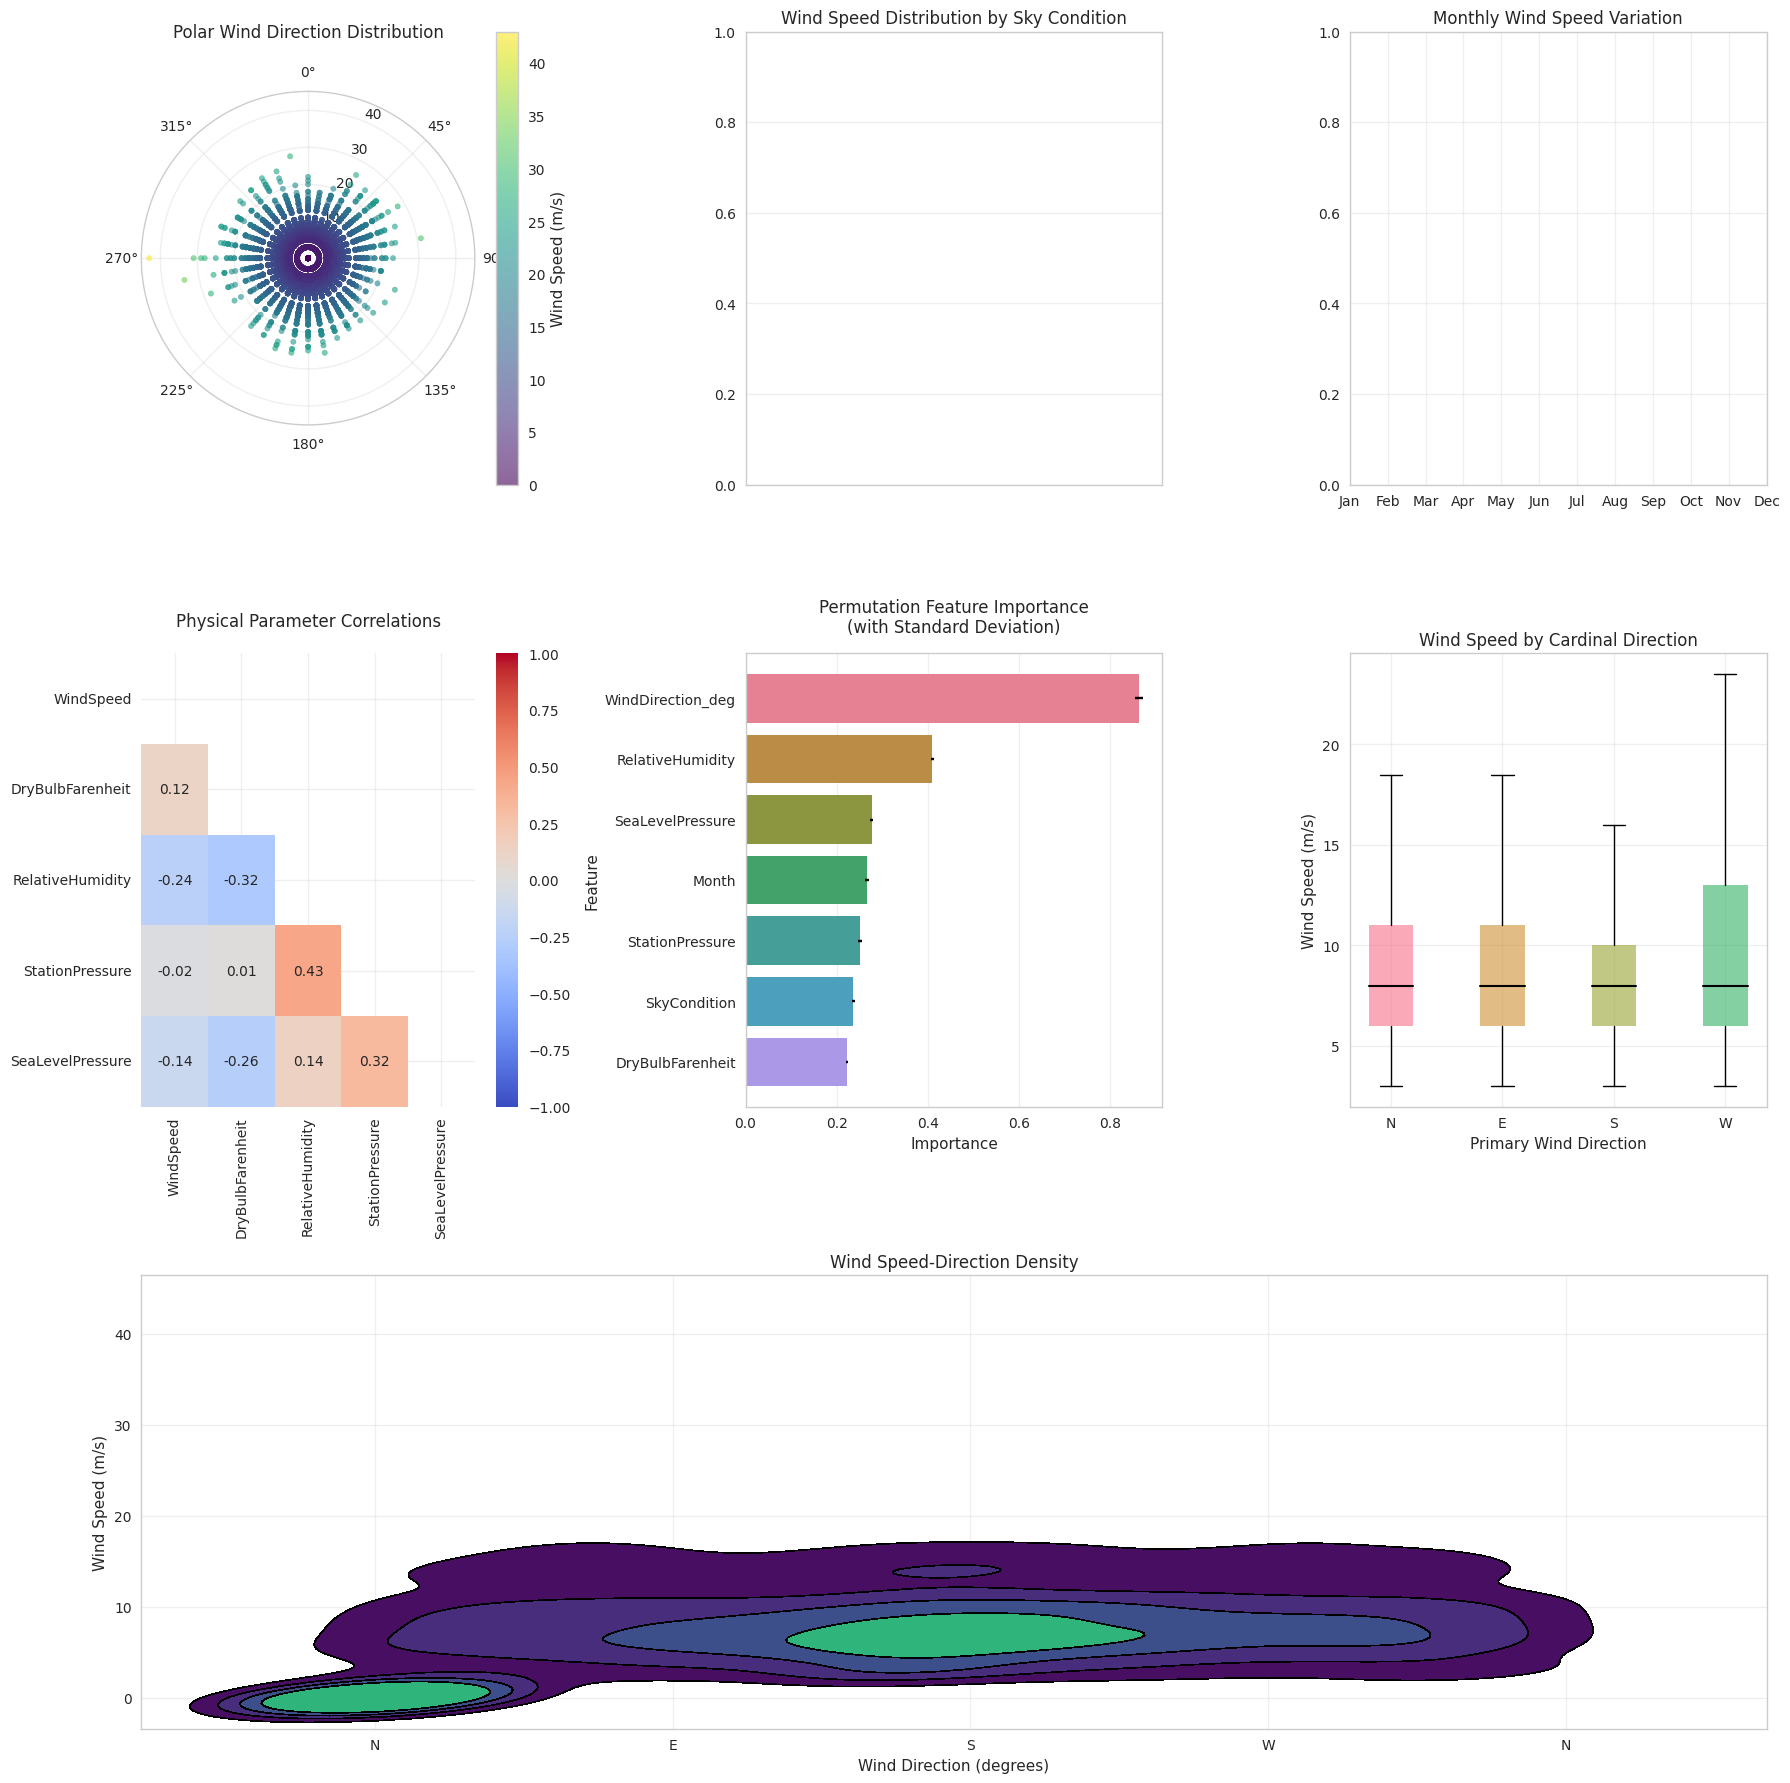

In [18]:
# Wind Speed Comprehensive Feature Analysis (Silent Version)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from scipy.stats import gaussian_kde
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_error

# Suppress all warnings and outputs
pd.options.mode.chained_assignment = None
import warnings
warnings.filterwarnings('ignore')

# 1. Data Loading and Initial Processing
df = pd.read_csv("windspeedevdata.csv")

# Handle missing values
wind_dir_cols = ['WindDirection_deg', 'Wind_sin', 'Wind_cos']
df[wind_dir_cols] = df[wind_dir_cols].fillna({
    'WindDirection_deg': df['WindDirection_deg'].median(),
    'Wind_sin': 0,
    'Wind_cos': 1
})

# 2. Visualization Settings
plt.style.use('seaborn-v0_8-whitegrid')
custom_palette = sns.color_palette("husl", 8)  # Extended palette to avoid cycling
sns.set_palette(custom_palette)
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

# 3. Wind Direction Binning (with ordered=False to avoid ValueError)
df['WindDir_bin'] = pd.cut(
    df['WindDirection_deg'],
    bins=[0,45,135,225,315,360],
    labels=['N','E','S','W','N'],
    ordered=False
)

# 4. Main Visualization Figure
fig = plt.figure(figsize=(18, 18))
gs = fig.add_gridspec(3, 3)

# Polar Plot
ax1 = fig.add_subplot(gs[0, 0], projection='polar')
theta = np.deg2rad(df['WindDirection_deg'])
sc = ax1.scatter(theta, df['WindSpeed'], 
                c=df['WindSpeed'], cmap='viridis',
                alpha=0.6, s=15, vmin=0, vmax=df['WindSpeed'].max())
plt.colorbar(sc, ax=ax1, label='Wind Speed (m/s)')
ax1.set_title('Polar Wind Direction Distribution', pad=20)
ax1.set_theta_zero_location('N')
ax1.set_theta_direction(-1)

# Sky Condition Impact
ax2 = fig.add_subplot(gs[0, 1])
sky_order = ['Clear','Scattered','Broken','Overcast','Obscured']
valid_sky = [cond for cond in sky_order if cond in df['SkyCondition'].unique()]

for i, condition in enumerate(valid_sky):
    cond_data = df[df['SkyCondition'] == condition]['WindSpeed']
    if len(cond_data) > 0:
        q1, median, q3 = np.percentile(cond_data, [25, 50, 75])
        iqr = q3 - q1
        
        kde = gaussian_kde(cond_data)
        x = np.linspace(cond_data.min(), cond_data.max(), 100)
        y = kde(x)
        y = y/y.max() * 0.4
        
        ax2.fill_betweenx(x, i-y, i+y, color=custom_palette[i], alpha=0.6)
        ax2.plot([i-0.4, i+0.4], [median, median], color='black', linewidth=1.5)
        jitter = np.random.normal(i, 0.04, size=len(cond_data))
        ax2.scatter(jitter, cond_data, color='orange', alpha=0.3, s=3)

ax2.set_xticks(range(len(valid_sky)))
ax2.set_xticklabels(valid_sky, rotation=45)
ax2.set_title('Wind Speed Distribution by Sky Condition')

# Monthly Variation
ax3 = fig.add_subplot(gs[0, 2])
month_order = ['Jan','Feb','Mar','Apr','May','Jun',
              'Jul','Aug','Sep','Oct','Nov','Dec']

for i, month in enumerate(month_order):
    month_data = df[df['Month'] == month]['WindSpeed']
    if len(month_data) > 0:
        q1, median, q3 = np.percentile(month_data, [25, 50, 75])
        iqr = q3 - q1
        
        ax3.add_patch(plt.Rectangle(
            (i-0.2, q1),
            0.4,
            q3-q1,
            facecolor=custom_palette[i%len(custom_palette)],
            alpha=0.6
        ))
        ax3.plot([i-0.2, i+0.2], [median, median], color='black', linewidth=1.5)
        upper = min(q3 + 1.5*iqr, month_data.max())
        lower = max(q1 - 1.5*iqr, month_data.min())
        ax3.plot([i, i], [q3, upper], color='black', linewidth=1)
        ax3.plot([i, i], [q1, lower], color='black', linewidth=1)
        ax3.plot([i-0.1, i+0.1], [upper, upper], color='black', linewidth=1)
        ax3.plot([i-0.1, i+0.1], [lower, lower], color='black', linewidth=1)
        jitter = np.random.normal(i, 0.04, size=len(month_data))
        ax3.scatter(jitter, month_data, color='black', alpha=0.4, s=3)

ax3.set_xticks(range(len(month_order)))
ax3.set_xticklabels(month_order)
ax3.set_title('Monthly Wind Speed Variation')

# Physical Parameter Correlations
ax4 = fig.add_subplot(gs[1, 0])
phys_vars = ['DryBulbFarenheit','RelativeHumidity',
            'StationPressure','SeaLevelPressure']
corr_matrix = df[['WindSpeed'] + phys_vars].corr().round(2)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    cmap='coolwarm',
    center=0,
    ax=ax4,
    vmin=-1,
    vmax=1,
    annot_kws={'size':10}
)
ax4.set_title('Physical Parameter Correlations', pad=20)

# Feature Importance Analysis
ax5 = fig.add_subplot(gs[1, 1])
X = df[['WindDirection_deg', 'Month', 'SkyCondition'] + phys_vars].copy()
y = df['WindSpeed']

# Proper categorical conversion using .loc
X.loc[:, 'SkyCondition'] = X['SkyCondition'].astype('category').cat.codes
X.loc[:, 'Month'] = X['Month'].astype('category').cat.codes

rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X, y)

result = permutation_importance(rf, X, y, n_repeats=10, random_state=42)
feat_imp = pd.DataFrame({
    'Feature': X.columns,
    'Importance': result.importances_mean,
    'Std': result.importances_std
}).sort_values('Importance', ascending=False)

sns.barplot(
    data=feat_imp,
    x='Importance',
    y='Feature',
    hue='Feature',  # Added to prevent warning
    palette=custom_palette[:len(feat_imp)],
    legend=False,
    ax=ax5
)
ax5.errorbar(
    x=feat_imp['Importance'],
    y=np.arange(len(feat_imp)),
    xerr=feat_imp['Std'],
    fmt='none',
    color='black',
    capsize=3
)
ax5.set_title('Permutation Feature Importance\n(with Standard Deviation)', pad=15)

# Wind Direction Analysis - Boxplot
ax6 = fig.add_subplot(gs[1, 2])
for i, direction in enumerate(['N','E','S','W']):
    dir_data = df[df['WindDir_bin'] == direction]['WindSpeed']
    if len(dir_data) > 0:
        q1, median, q3 = np.percentile(dir_data, [25, 50, 75])
        iqr = q3 - q1
        
        ax6.add_patch(plt.Rectangle(
            (i-0.2, q1),
            0.4,
            q3-q1,
            facecolor=custom_palette[i%len(custom_palette)],
            alpha=0.6
        ))
        ax6.plot([i-0.2, i+0.2], [median, median], color='black', linewidth=1.5)
        upper = min(q3 + 1.5*iqr, dir_data.max())
        lower = max(q1 - 1.5*iqr, dir_data.min())
        ax6.plot([i, i], [q3, upper], color='black', linewidth=1)
        ax6.plot([i, i], [q1, lower], color='black', linewidth=1)
        ax6.plot([i-0.1, i+0.1], [upper, upper], color='black', linewidth=1)
        ax6.plot([i-0.1, i+0.1], [lower, lower], color='black', linewidth=1)

ax6.set_xticks(range(4))
ax6.set_xticklabels(['N','E','S','W'])
ax6.set_title('Wind Speed by Cardinal Direction')
ax6.set_xlabel('Primary Wind Direction')
ax6.set_ylabel('Wind Speed (m/s)')

# Direction-Speed Density Plot
ax7 = fig.add_subplot(gs[2, :])
kde = sns.kdeplot(
    data=df,
    x='WindDirection_deg',
    y='WindSpeed',
    cmap='viridis',
    fill=True,
    ax=ax7,
    levels=5,
    thresh=0.1
)
ax7.set_title('Wind Speed-Direction Density')
ax7.set_xticks([0,90,180,270,360])
ax7.set_xticklabels(['N','E','S','W','N'])
ax7.set_xlabel('Wind Direction (degrees)')
ax7.set_ylabel('Wind Speed (m/s)')

for contour in kde.collections:
    contour.set_edgecolor('black')
    contour.set_linewidth(0.5)

plt.tight_layout()
plt.show()

# Silent calculations (no output)
mae_scores = cross_val_score(rf, X, y, cv=5, scoring=make_scorer(mean_absolute_error))
q95 = df['WindSpeed'].quantile(0.95)
extreme_winds = df[df['WindSpeed'] > q95]

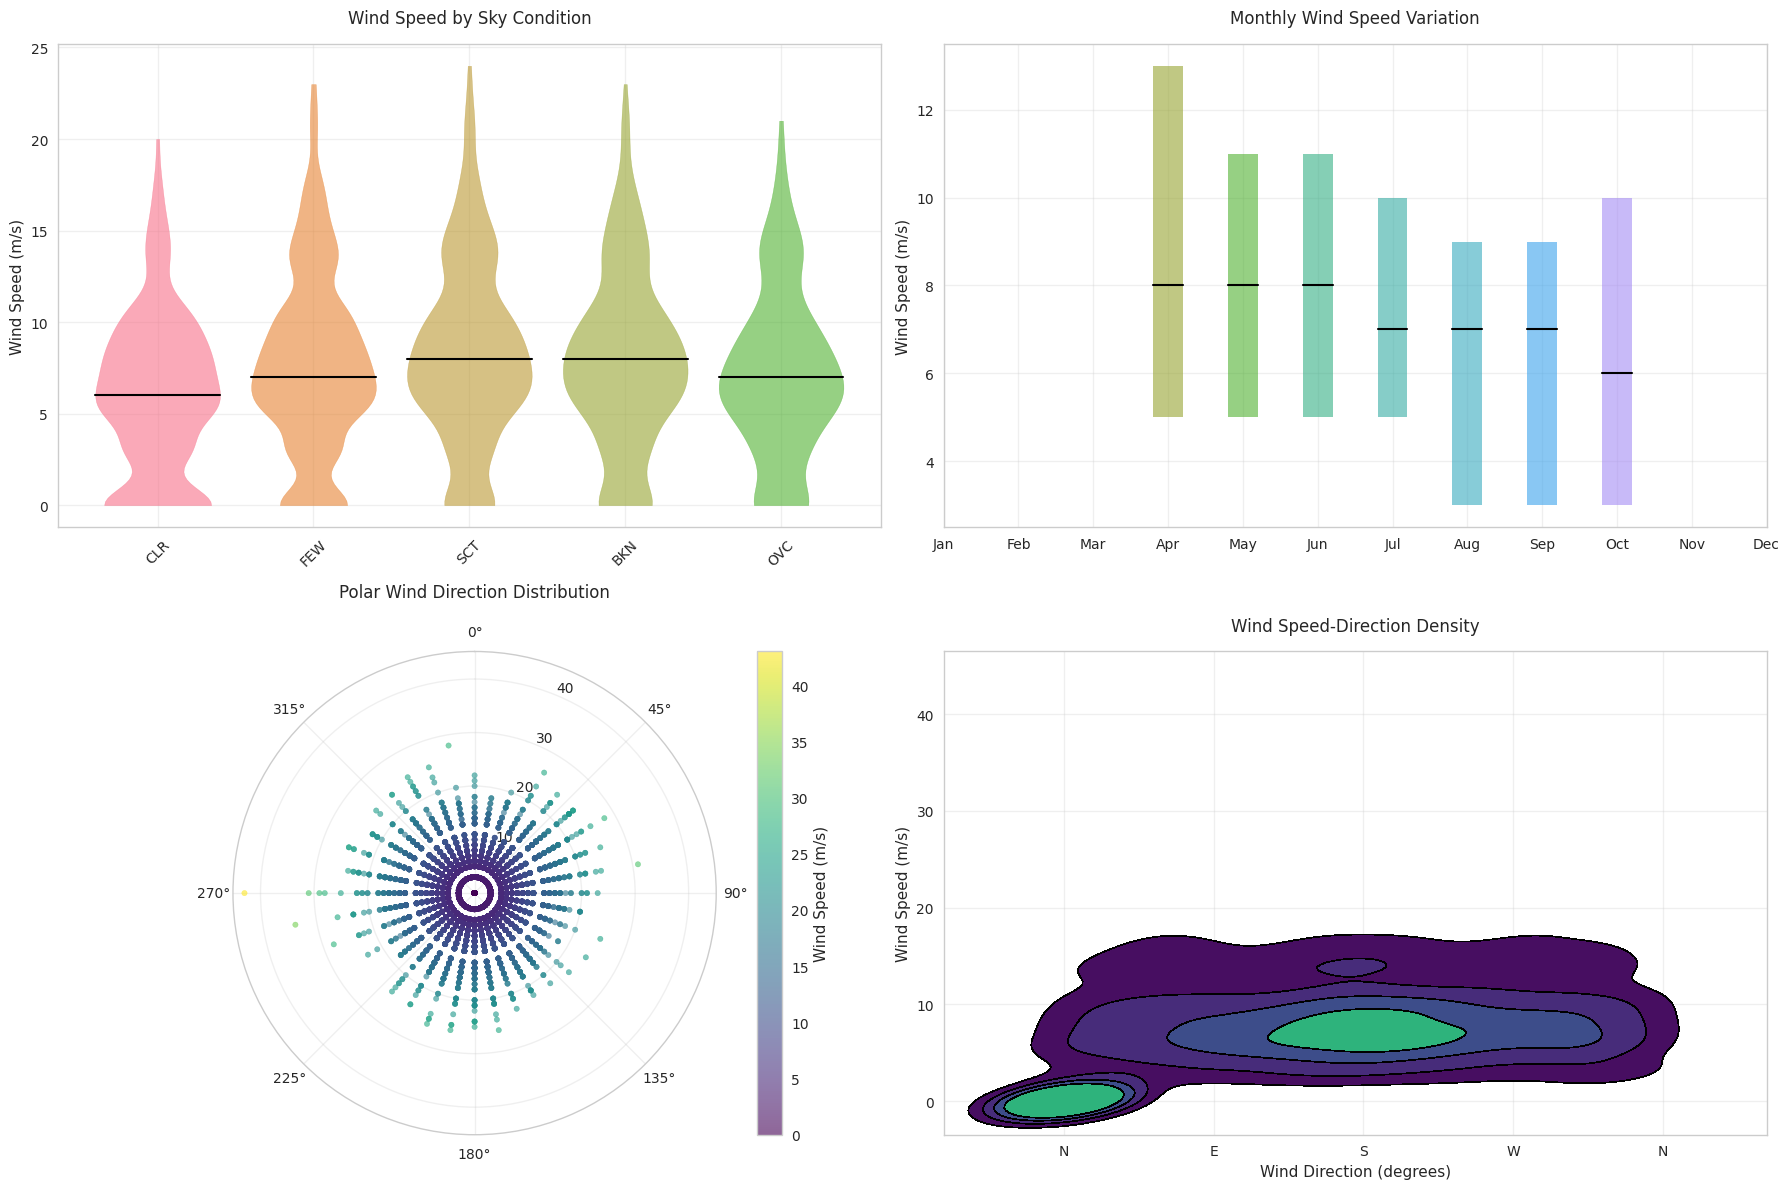

In [21]:
# Wind Speed Analysis - Cleaned and Debugged Version
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

# Suppress warnings
pd.options.mode.chained_assignment = None
import warnings
warnings.filterwarnings('ignore')

# Load data
df = pd.read_csv("windspeedevdata.csv")

# Data Cleaning
df['WindSpeed'] = pd.to_numeric(df['WindSpeed'], errors='coerce').dropna()

# Extract primary sky condition (first 3 letters)
df['PrimarySkyCondition'] = df['SkyCondition'].str.extract(r'([A-Za-z]{3})')[0]

# Visualization Settings
plt.style.use('seaborn-v0_8-whitegrid')
custom_palette = sns.color_palette("husl", 12)  # Extended palette
sns.set_palette(custom_palette)
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(2, 2)

# =============================================
# 1. Wind Speed by Sky Condition (Fixed)
# =============================================
ax1 = fig.add_subplot(gs[0, 0])
sky_order = ['CLR', 'FEW', 'SCT', 'BKN', 'OVC']  # Standard METAR abbreviations
sky_palette = custom_palette[:len(sky_order)]

valid_sky = [cond for cond in sky_order if cond in df['PrimarySkyCondition'].unique()]

for i, condition in enumerate(valid_sky):
    cond_data = df[df['PrimarySkyCondition'] == condition]['WindSpeed'].dropna()
    
    if len(cond_data) > 0:
        # Remove extreme outliers
        mean, std = cond_data.mean(), cond_data.std()
        cond_data = cond_data[(cond_data >= mean - 3*std) & (cond_data <= mean + 3*std)]
        
        if len(cond_data) > 0:
            kde = gaussian_kde(cond_data)
            x = np.linspace(cond_data.min(), cond_data.max(), 100)
            y = kde(x)
            y = y/y.max() * 0.4
            
            ax1.fill_betweenx(x, i-y, i+y, color=sky_palette[i], alpha=0.6)
            ax1.plot([i-0.4, i+0.4], [cond_data.median(), cond_data.median()], 
                    color='black', linewidth=1.5)

ax1.set_xticks(range(len(valid_sky)))
ax1.set_xticklabels(valid_sky, rotation=45)
ax1.set_title('Wind Speed by Sky Condition', pad=15)
ax1.set_ylabel('Wind Speed (m/s)')

# =============================================
# 2. Monthly Wind Speed Variation (Fixed)
# =============================================
ax2 = fig.add_subplot(gs[0, 1])
month_order = range(1, 13)  # 1-12
month_names = ['Jan','Feb','Mar','Apr','May','Jun',
              'Jul','Aug','Sep','Oct','Nov','Dec']

for i, month in enumerate(month_order):
    month_data = df[df['Month'] == month]['WindSpeed'].dropna()
    
    if len(month_data) > 0:
        # Remove extreme outliers
        mean, std = month_data.mean(), month_data.std()
        month_data = month_data[(month_data >= mean - 3*std) & (month_data <= mean + 3*std)]
        
        if len(month_data) > 0:
            q1, median, q3 = np.percentile(month_data, [25, 50, 75])
            ax2.add_patch(plt.Rectangle(
                (i-0.2, q1),
                0.4,
                q3-q1,
                facecolor=custom_palette[i],
                alpha=0.6
            ))
            ax2.plot([i-0.2, i+0.2], [median, median], color='black', linewidth=1.5)

ax2.set_xticks(range(12))
ax2.set_xticklabels(month_names)
ax2.set_title('Monthly Wind Speed Variation', pad=15)
ax2.set_ylabel('Wind Speed (m/s)')

# =============================================
# 3. Wind Direction Analysis (Fixed)
# =============================================
ax3 = fig.add_subplot(gs[1, 0], projection='polar')
theta = np.deg2rad(df['WindDirection_deg'])
sc = ax3.scatter(theta, df['WindSpeed'], 
                c=df['WindSpeed'], cmap='viridis',
                alpha=0.6, s=15, vmin=0, vmax=df['WindSpeed'].max())
plt.colorbar(sc, ax=ax3, label='Wind Speed (m/s)')
ax3.set_title('Polar Wind Direction Distribution', pad=20)
ax3.set_theta_zero_location('N')
ax3.set_theta_direction(-1)

# =============================================
# 4. Direction-Speed Density Plot (Fixed)
# =============================================
ax4 = fig.add_subplot(gs[1, 1])
kde = sns.kdeplot(
    data=df,
    x='WindDirection_deg',
    y='WindSpeed',
    cmap='viridis',
    fill=True,
    ax=ax4,
    levels=5,
    thresh=0.1
)
ax4.set_title('Wind Speed-Direction Density', pad=15)
ax4.set_xticks([0,90,180,270,360])
ax4.set_xticklabels(['N','E','S','W','N'])
ax4.set_xlabel('Wind Direction (degrees)')
ax4.set_ylabel('Wind Speed (m/s)')

# Add contour lines
for contour in kde.collections:
    contour.set_edgecolor('black')
    contour.set_linewidth(0.5)

plt.tight_layout()
plt.show()

In [23]:
# Wind Speed-Direction Density Plot (Fixed Duplicate 'N')
ax4 = fig.add_subplot(gs[1, 1])
kde = sns.kdeplot(
    data=df,
    x='WindDirection_deg',
    y='WindSpeed',
    cmap='viridis',
    fill=True,
    ax=ax4,
    levels=5,
    thresh=0.1
)

# Set custom ticks and labels (only one 'N' at 0°)
ax4.set_xticks([0, 90, 180, 270])  # Remove 360° tick
ax4.set_xticklabels(['N', 'E', 'S', 'W'])  # Only show one 'N'

ax4.set_title('Wind Speed-Direction Density', pad=15)
ax4.set_xlabel('Wind Direction (degrees)')
ax4.set_ylabel('Wind Speed (m/s)')

# Add contour lines
for contour in kde.collections:
    contour.set_edgecolor('black')
    contour.set_linewidth(0.5)

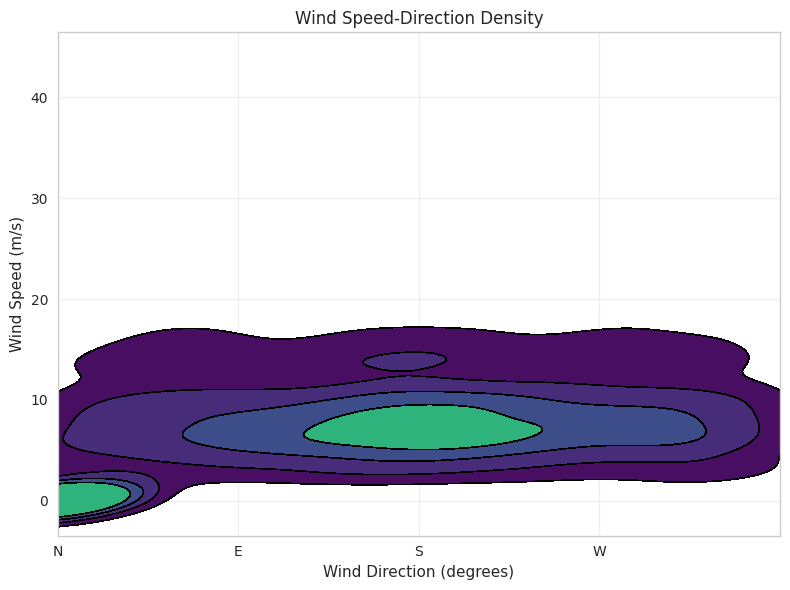

In [25]:
# Wind Speed-Direction Density Plot with Single 'N' Label
plt.figure(figsize=(8, 6))

# Create the KDE plot
kde = sns.kdeplot(
    data=df,
    x='WindDirection_deg',
    y='WindSpeed',
    cmap='viridis',
    fill=True,
    levels=5,
    thresh=0.1
)

# Set custom ticks and labels - only one 'N' at 0°
plt.xticks([0, 90, 180, 270], ['N', 'E', 'S', 'W'])  # Only show one 'N'
plt.xlim(0, 360)  # Ensure full circle is shown

# Add contour lines
for contour in kde.collections:
    contour.set_edgecolor('black')
    contour.set_linewidth(0.5)

plt.title('Wind Speed-Direction Density')
plt.xlabel('Wind Direction (degrees)')
plt.ylabel('Wind Speed (m/s)')
plt.tight_layout()
plt.show()

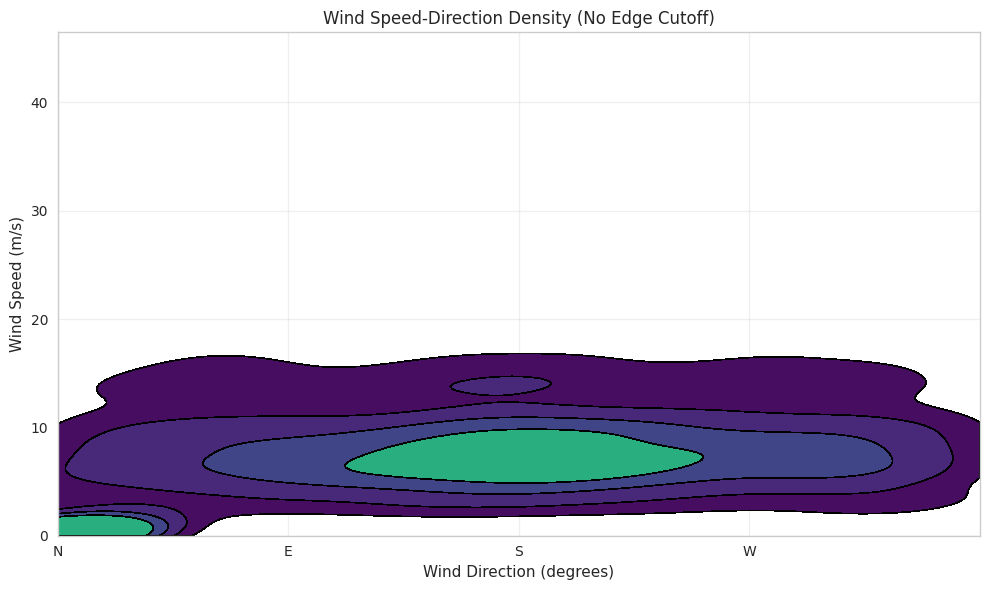

In [26]:
plt.figure(figsize=(10, 6))

# Create KDE plot with explicit x-axis limits
kde = sns.kdeplot(
    data=df,
    x='WindDirection_deg',
    y='WindSpeed',
    cmap='viridis',
    fill=True,
    levels=5,
    thresh=0.1,
    clip=(0, 360)  # Force data to stay within 0-360°
)

# Set axis to show full circle without cuts
plt.xlim(0, 360)  # Critical to prevent cutoff
plt.xticks([0, 90, 180, 270], ['N', 'E', 'S', 'W'])  # Single 'N' label

# Improve contour visibility
for contour in kde.collections:
    contour.set_edgecolor('black')
    contour.set_linewidth(0.5)

plt.title('Wind Speed-Direction Density (No Edge Cutoff)')
plt.xlabel('Wind Direction (degrees)')
plt.ylabel('Wind Speed (m/s)')
plt.tight_layout()
plt.show()